# 1.0 Setup

Import modules

In [ ]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier 
from matplotlib import pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.svm import SVC

np.random.seed(1)

# 2.0 Load data
Load data (it's already cleaned and preprocessed)

In [ ]:
X_train = pd.read_csv('airbnb_train_X_price_gte_150.csv') 
y_train = pd.read_csv('airbnb_train_y_price_gte_150.csv') 
X_test = pd.read_csv('airbnb_test_X_price_gte_150.csv') 
y_test = pd.read_csv('airbnb_test_y_price_gte_150.csv') 

# 3. Model the data
First, let's create a dataframe to load the model performance metrics into.

In [ ]:
performance = pd.DataFrame({"model": [], "Accuracy": [], "Precision": [], "Recall": [], "F1": []})

# 4.0 Polynomial SVM Classifier - Random Search 

hyperparameters that can be tuned for SVM with a polynomial kernel using randomized search:

C: the regularization parameter. A larger C value allows the algorithm to better fit the training data but may result in overfitting. A smaller C value will result in a smoother decision boundary, but may result in underfitting.

degree: the degree of the polynomial kernel. A higher degree allows the model to capture more complex interactions between features, but may result in overfitting.

gamma: the kernel coefficient. A higher gamma value will result in a more complex decision boundary and may result in overfitting. A lower gamma value will result in a smoother decision boundary and may result in underfitting.

coef0: the independent term in the kernel function. A non-zero value of coef0 allows for more complex polynomial functions and may improve the model's ability to fit the training data, but may result in overfitting.

In [ ]:
score_measure = "precision"
kfolds = 5

param_rand = {
    'C': np.arange(5,15),
    'degree': [3, 4,5],
    'gamma': ['scale', 'auto'],
    'coef0': np.arange(1,5)
}

svm_poly_model = SVC(kernel="poly")
rand_search = RandomizedSearchCV(estimator = svm_poly_model, param_distributions=param_rand, cv=kfolds, n_iter=20,
                           scoring=score_measure, verbose=1, n_jobs=-1,  # n_jobs=-1 will utilize all available CPUs 
                           return_train_score=True)

_ = rand_search.fit(X_train,np.ravel(y_train))

print(f"The best {score_measure} score is {rand_search.best_score_}")
print(f"... with parameters: {rand_search.best_params_}")

best_SVM_poly = rand_search.best_estimator_

Fitting 5 folds for each of 20 candidates, totalling 100 fits
The best precision score is 0.8524973031907106
... with parameters: {'gamma': 'auto', 'degree': 4, 'coef0': 1, 'C': 14}


In [ ]:
c_matrix = confusion_matrix(y_test, rand_search.predict(X_test))
TP = c_matrix[1][1]
TN = c_matrix[0][0]
FP = c_matrix[0][1]
FN = c_matrix[1][0]
performance = pd.concat([performance, pd.DataFrame({'model':"Ploy_SVC_random", 
                                                    'Accuracy': [(TP+TN)/(TP+TN+FP+FN)], 
                                                    'Precision': [TP/(TP+FP)], 
                                                    'Recall': [TP/(TP+FN)], 
                                                    'F1': [2*TP/(2*TP+FP+FN)]
                                                     }, index=[0])])

# 4.1 Polynomial SVM Classifier - Grid Search 

In [ ]:
score_measure = "precision"
kfolds = 5

C= rand_search.best_params_['C']
degree = rand_search.best_params_['degree']
gamma = rand_search.best_params_['gamma']
coef0 = rand_search.best_params_['coef0']

param_grid = {
    'C': np.arange(C-2,C+2),
    'degree': np.arange(degree-2,degree+2),
    'gamma': [gamma],
    'coef0': np.arange(coef0-2,coef0+2),
}

svm_poly_model = SVC(kernel="poly")
grid_search = GridSearchCV(estimator = svm_poly_model, param_grid=param_grid, cv=kfolds, 
                           scoring=score_measure, verbose=1, n_jobs=-1,  # n_jobs=-1 will utilize all available CPUs 
                           return_train_score=True)

_ = grid_search.fit(X_train, np.ravel(y_train))

print(f"The best {score_measure} score is {grid_search.best_score_}")
print(f"... with parameters: {grid_search.best_params_}")

best_svm_poly_grid = grid_search.best_estimator_

Fitting 5 folds for each of 64 candidates, totalling 320 fits
The best precision score is 0.8536504108406504
... with parameters: {'C': 15, 'coef0': 1, 'degree': 3, 'gamma': 'auto'}


In [ ]:
c_matrix = confusion_matrix(y_test, grid_search.predict(X_test))
TP = c_matrix[1][1]
TN = c_matrix[0][0]
FP = c_matrix[0][1]
FN = c_matrix[1][0]
performance = pd.concat([performance, pd.DataFrame({'model':"Poly_SVC_Grid", 
                                                    'Accuracy': [(TP+TN)/(TP+TN+FP+FN)], 
                                                    'Precision': [TP/(TP+FP)], 
                                                    'Recall': [TP/(TP+FN)], 
                                                    'F1': [2*TP/(2*TP+FP+FN)]
                                                     }, index=[0])])


# 3.0 Decision Tree Classifier
Conduct an initial random search across a wide range of possible parameters.

# 3.1 Decision Tree Classifier-Random Search

In [ ]:
score_measure = "precision"
kfolds = 5

param_grid = {
    'min_samples_split': np.arange(2,30),  
    'min_samples_leaf': np.arange(1,30),
    'min_impurity_decrease': np.arange(0.0001, 0.01, 0.0005),
    'max_leaf_nodes': np.arange(5, 200), 
    'max_depth': np.arange(1,50), 
    'criterion': ['entropy', 'gini'],
    
}

dtree = DecisionTreeClassifier()
rand_search = RandomizedSearchCV(estimator = dtree, param_distributions=param_grid, cv=kfolds, n_iter=100,
                           scoring=score_measure, verbose=0, n_jobs=-1,  # n_jobs=-1 will utilize all available CPUs 
                           return_train_score=True)

_ = rand_search.fit(X_train, np.ravel(y_train))

print(f"The best {score_measure} score is {rand_search.best_score_}")
print(f"... with parameters: {rand_search.best_params_}")

best_DTree = rand_search.best_estimator_

The best precision score is 0.8578221739557021
... with parameters: {'min_samples_split': 9, 'min_samples_leaf': 6, 'min_impurity_decrease': 0.0036, 'max_leaf_nodes': 174, 'max_depth': 21, 'criterion': 'entropy'}


In [ ]:
c_matrix = confusion_matrix(y_test, rand_search.predict(X_test))
TP = c_matrix[1][1]
TN = c_matrix[0][0]
FP = c_matrix[0][1]
FN = c_matrix[1][0]
performance = pd.concat([performance, pd.DataFrame({'model':"Dtree_Random", 
                                                    'Accuracy': [(TP+TN)/(TP+TN+FP+FN)], 
                                                    'Precision': [TP/(TP+FP)], 
                                                    'Recall': [TP/(TP+FN)], 
                                                    'F1': [2*TP/(2*TP+FP+FN)]
                                                     }, index=[0])])

# 3.2 Decision Tree Classifier-Grid Search

In [ ]:
score_measure = "precision"
kfolds = 5
min_samples_split = rand_search.best_params_['min_samples_split']
min_samples_leaf = rand_search.best_params_['min_samples_leaf']
min_impurity_decrease = rand_search.best_params_['min_impurity_decrease']
max_leaf_nodes = rand_search.best_params_['max_leaf_nodes']
max_depth = rand_search.best_params_['max_depth']
criterion = rand_search.best_params_['criterion']

param_grid = {
    'min_samples_split': np.arange(min_samples_split-2,min_samples_split+2),  
    'min_samples_leaf': np.arange(min_samples_leaf-2,min_samples_leaf+2),
    'min_impurity_decrease': np.arange(min_impurity_decrease-0.0001, min_impurity_decrease+0.0001, 0.00005),
    'max_leaf_nodes': np.arange(max_leaf_nodes-2,max_leaf_nodes+2), 
    'max_depth': np.arange(max_depth-2,max_depth+2), 
    'criterion': [criterion]
}

dtree = DecisionTreeClassifier()
grid_search = GridSearchCV(estimator = dtree, param_grid=param_grid, cv=kfolds, 
                           scoring=score_measure, verbose=1, n_jobs=-1,  # n_jobs=-1 will utilize all available CPUs 
                           return_train_score=True)

_ = grid_search.fit(X_train, np.ravel(y_train))

print(f"The best {score_measure} score is {grid_search.best_score_}")
print(f"... with parameters: {grid_search.best_params_}")

best_DTree_grid = grid_search.best_estimator_

Fitting 5 folds for each of 1024 candidates, totalling 5120 fits
The best precision score is 0.8601471152357961
... with parameters: {'criterion': 'entropy', 'max_depth': 19, 'max_leaf_nodes': 173, 'min_impurity_decrease': 0.0035, 'min_samples_leaf': 6, 'min_samples_split': 7}


In [ ]:
c_matrix = confusion_matrix(y_test, grid_search.predict(X_test))
TP = c_matrix[1][1]
TN = c_matrix[0][0]
FP = c_matrix[0][1]
FN = c_matrix[1][0]
performance = pd.concat([performance, pd.DataFrame({'model':"Dtree_Grid", 
                                                    'Accuracy': [(TP+TN)/(TP+TN+FP+FN)], 
                                                    'Precision': [TP/(TP+FP)], 
                                                    'Recall': [TP/(TP+FN)], 
                                                    'F1': [2*TP/(2*TP+FP+FN)]
                                                     }, index=[0])])

# 3.3 Importance of features

In [ ]:
np.round(grid_search.best_estimator_.feature_importances_,2)

array([0.  , 0.  , 0.07, 0.09, 0.68, 0.01, 0.01, 0.06, 0.  , 0.  , 0.  ,
       0.01, 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.01, 0.03, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.01, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ])

# 3.4 Diagrams of DTrees

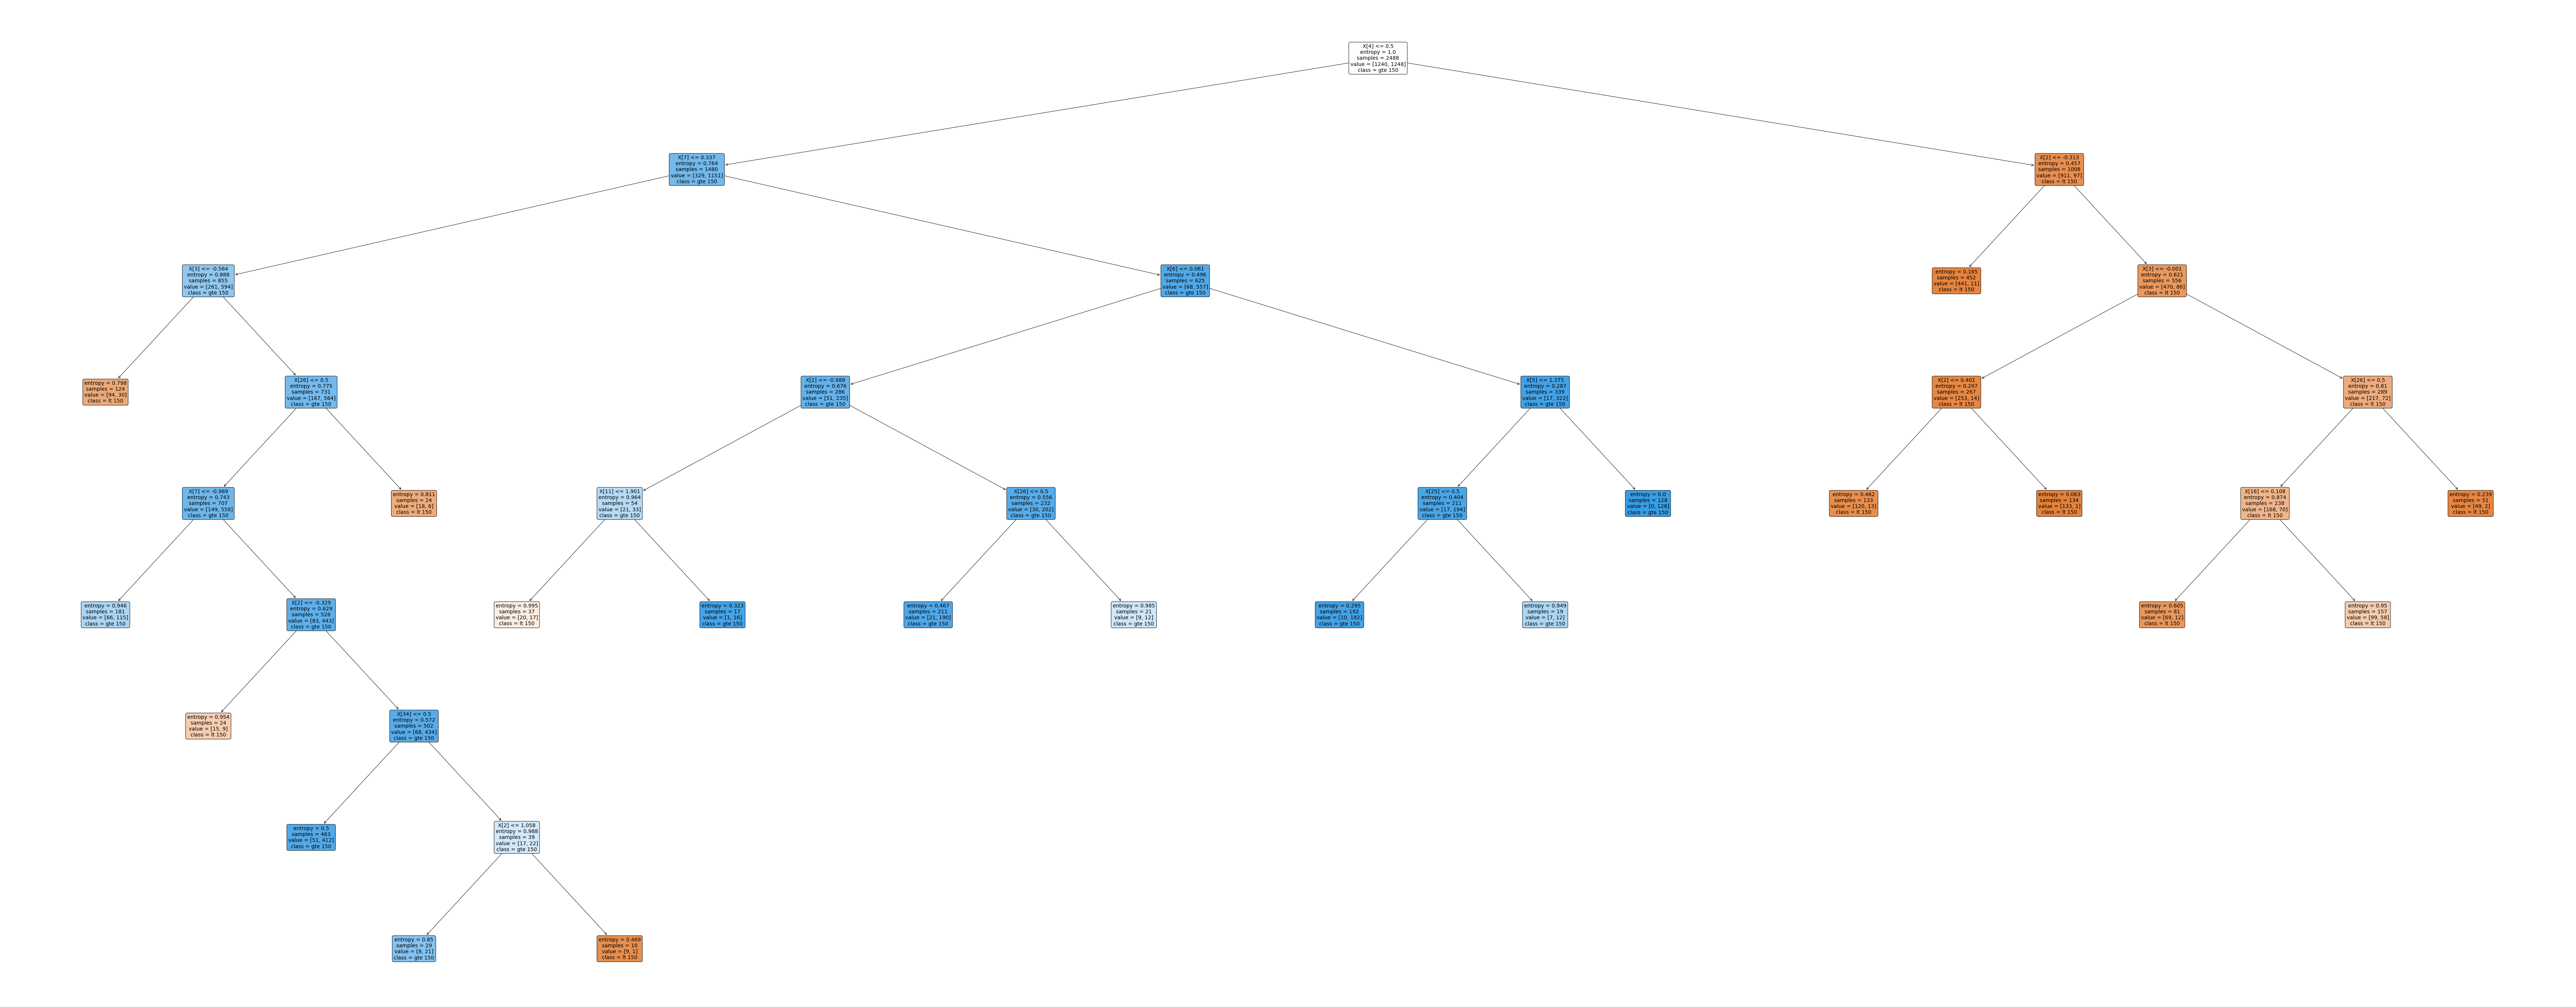

In [ ]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(125,50))
tree = plot_tree(grid_search.best_estimator_, 
              #feature_names=train_inputs.columns.values, # our feature names are stripped from the data set
              class_names=['lt 150', 'gte 150'], 
              filled=True, 
              rounded=True, 
              fontsize=14)

# 4.0 Sorted by Precision, the best models are:

In [ ]:

performance.sort_values(by=['Precision'])

,model,Accuracy,Precision,Recall,F1
0,Ploy_SVC_random,0.861293,0.845045,0.883239,0.863720
0,Poly_SVC_Grid,0.862231,0.850365,0.877589,0.863763
0,Dtree_Grid,0.847235,0.855212,0.834275,0.844614
0,Dtree_Random,0.848172,0.856867,0.834275,0.845420


# 5.0 Analysis

By seeing the Precision score of 4 models we excuted, I got better precision value of 85.68% for Decision tree using Random search model.
Remaining models like Poly_SVC using random and Grid search models takes more execution and gives less precision than Decision tree models. 
therefore Decision tree using random search model executions in very less time and given better Precision value.